In [1]:
import numpy as np
import time
import h5py

In [2]:
def load_OASIS():
    with h5py.File('..\..\Datasets\OASIS_balanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('trainX'))
        trainY = np.array(G1.get('trainY'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('testX'))
        testY = np.array(G2.get('testY'))

        return trainX, trainY, testX, testY

In [3]:
def load_ADNI():
    with h5py.File('..\..\Datasets\ADNI_enhanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('x_train'))
        trainY = np.array(G1.get('y_train'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('x_test'))
        testY = np.array(G2.get('y_test'))

        return trainX, trainY, testX, testY

In [4]:
dataset = 'ADlNI'
if dataset == 'ADNI':
    x_train, y_train, x_test, y_test = load_ADNI()
else:
    x_train, y_train, x_test, y_test = load_OASIS()

In [5]:
raw_pixels = False #use this to choose between raw pixels and VGG16 features

In [6]:
# make it 3D (for VGG16)
if (raw_pixels == False):
    if dataset == 'ADNI':
        x_train = np.repeat(x_train, 3, axis=3)
        x_test = np.repeat(x_test, 3, axis=3)
    else:
        x_train = np.expand_dims(x_train, axis=-1)
        x_train = np.repeat(x_train, 3, axis=3)
        x_test = np.expand_dims(x_test, axis=-1)
        x_test = np.repeat(x_test, 3, axis=3)
print('x_train shape:', x_train.shape)

x_train shape: (8192, 176, 176, 3)


In [7]:
if (raw_pixels  == False):

    from tensorflow.keras.applications.vgg16 import VGG16
    if dataset == 'ADNI':
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(218, 182, 3))
    else:
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    
    # Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
    for layer in VGG_model.layers:
        layer.trainable = False

    VGG_model.summary()  # Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 44, 128)       0     

In [8]:
if (raw_pixels == False):
# Now, let us use features from convolutional network for KNN
    print("extracting VGG16 features")
    feature_extractor=VGG_model.predict(x_train)
    print("reshaping features")
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
    # print(feature_extractor.shape)
    # print(features.shape)

    X_Train = features #This is our X input to Logistic Regression.

    #Send test data through same feature extractor process
    X_test_feature = VGG_model.predict(x_test)
    X_Test = X_test_feature.reshape(X_test_feature.shape[0], -1)
    print(X_Test.shape)
    print(X_Train.shape)

extracting VGG16 features
reshaping features
(2560, 12800)
(8192, 12800)


In [9]:
#BELOW CODE IS FOR USING DIRECT PIXELS.
if (raw_pixels != False):
    print('using raw pixels for classification:')
    print ('old shape',x_train.shape)
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
    print('new shape',x_train.shape)
    X_Train = x_train
    X_Test = x_test

In [10]:
error_rate = []
from sklearn.neighbors import KNeighborsClassifier
# Will take some time
for i in range(1,10):
    print ('KNN with neighbor',i)
    knn = KNeighborsClassifier(n_neighbors=i, metric='minkowski', p=2)
    knn.fit(X_Train,y_train)
    pred_i = knn.predict(X_Test)
    error_rate.append(np.mean(pred_i != y_test))
    

KNN with neighbor 1
KNN with neighbor 2
KNN with neighbor 3
KNN with neighbor 4
KNN with neighbor 5
KNN with neighbor 6
KNN with neighbor 7
KNN with neighbor 8
KNN with neighbor 9


Text(0, 0.5, 'Error Rate')

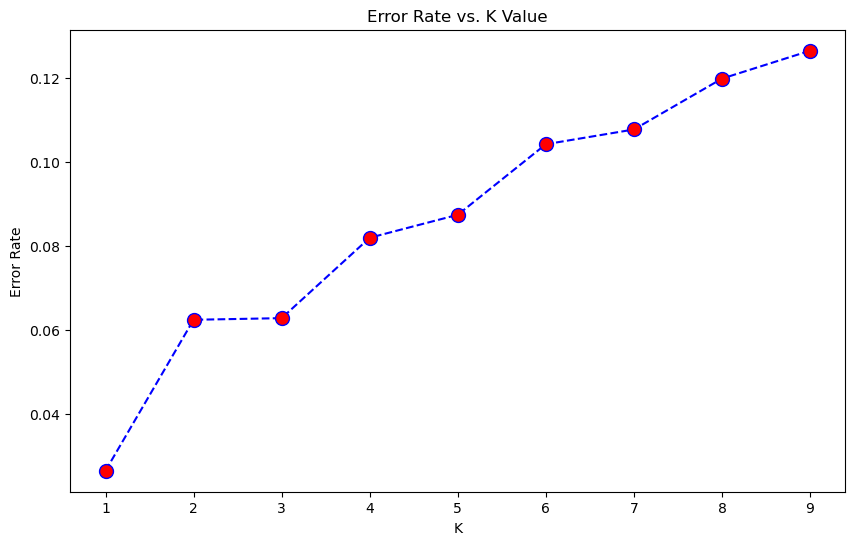

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [12]:
# KNN for optimal K value
print("KNN")

model = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', p = 2)

# Train the model on training data
model.fit(X_Train, y_train) # For sklearn no one hot encoding


KNN


KNeighborsClassifier(n_neighbors=2)

In [13]:
print("predicting for test")
#Now predict using the trained RF model.
prediction = model.predict(X_Test)
#Inverse le transform to get original label back.

print("estimating accuracy")
#Print overall accuracy
from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(y_true=y_test, y_pred=prediction, labels=[0,1,2,3], samplewise=False)
tn = mcm[:,0,0]
tp = mcm[:,1,1]
fp = mcm[:,0,1]
fn = mcm[:,1,0]
specificity = tn/(tn+fp)
print("Specificity or TNR",np.mean(specificity))

sensitivity = tp/(tp+fn)
print("Sensitivity or TPR or Recall",np.mean(sensitivity))

print("FNR ", 1-np.mean(sensitivity))

print("FPR", 1-np.mean(specificity))

from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(y_test, prediction))

y_pred_proba=model.predict_proba(X_Test)

auc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

#print AUC score
print("AUC =",auc)
print("--- %s minutes ---" % str((time.time() - start_time)/60.0))

predicting for test
estimating accuracy
Specificity or TNR 0.9791337680320079
Sensitivity or TPR or Recall 0.9376222499806337
FNR  0.062377750019366296
FPR 0.020866231967992088
Accuracy =  0.9375
AUC = 0.98901365877202
--- 3.64909663995107 minutes ---


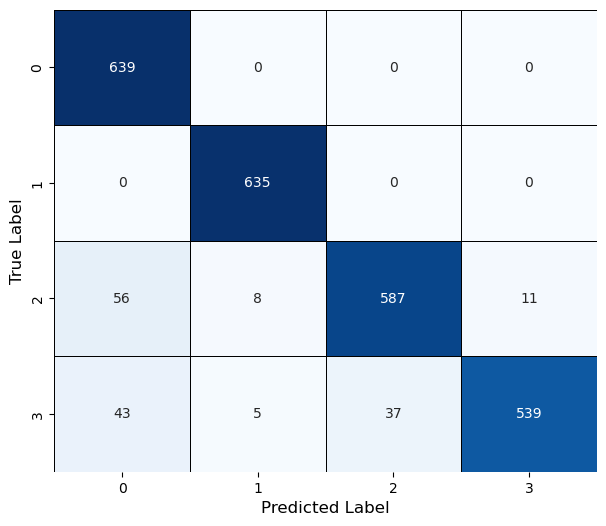

In [14]:
#%%
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, prediction)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.savefig("CM_KNN-OASIS.pdf")